In [2]:
import numpy as np
import tensorflow as tf
import random
import tensorflow_datasets as tfds
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import os
import sys
from datetime import datetime

2025-03-31 10:20:23.455415: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-31 10:20:23.462237: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-31 10:20:23.472790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743409223.494632  158968 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743409223.499915  158968 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-31 10:20:23.519805: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
# Work-around for loading a module from a parent folder in Jupyter/Notebooks
parent_dir = os.path.abspath(os.path.join('..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from modules.autoencoders import VanillaAutoencoder, ConvolutedAutoencoder, VariationalAutoencoder, Autoencoder#, ConditionedVariationalAutoencoder

In [4]:
# Caricamento dei dati
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
# Caricamento dei dati
train_ds, test_ds = tfds.load('mnist', split=['train', 'test'], shuffle_files=True, batch_size=-1, as_supervised=True)
x_train, y_train = tfds.as_numpy(train_ds)
x_test, y_test = tfds.as_numpy(test_ds)
#x_train = x_train[:,:,:,0]
#x_test = x_test[:,:,:,0]

2025-03-31 10:20:31.071488: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-03-31 10:20:31.246099: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


In [6]:
# Normalizzazione dei pixel a [0, 1]
norm_x_train = x_train.astype('float32') / 255.
norm_x_test = x_test.astype('float32') / 255.

In [7]:
classes = np.unique(y_train)
n_classes = len(classes)

In [8]:
#model_name = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = "20250320_175412"
model_path = os.path.join("..", "models")

# Dataset Analisys

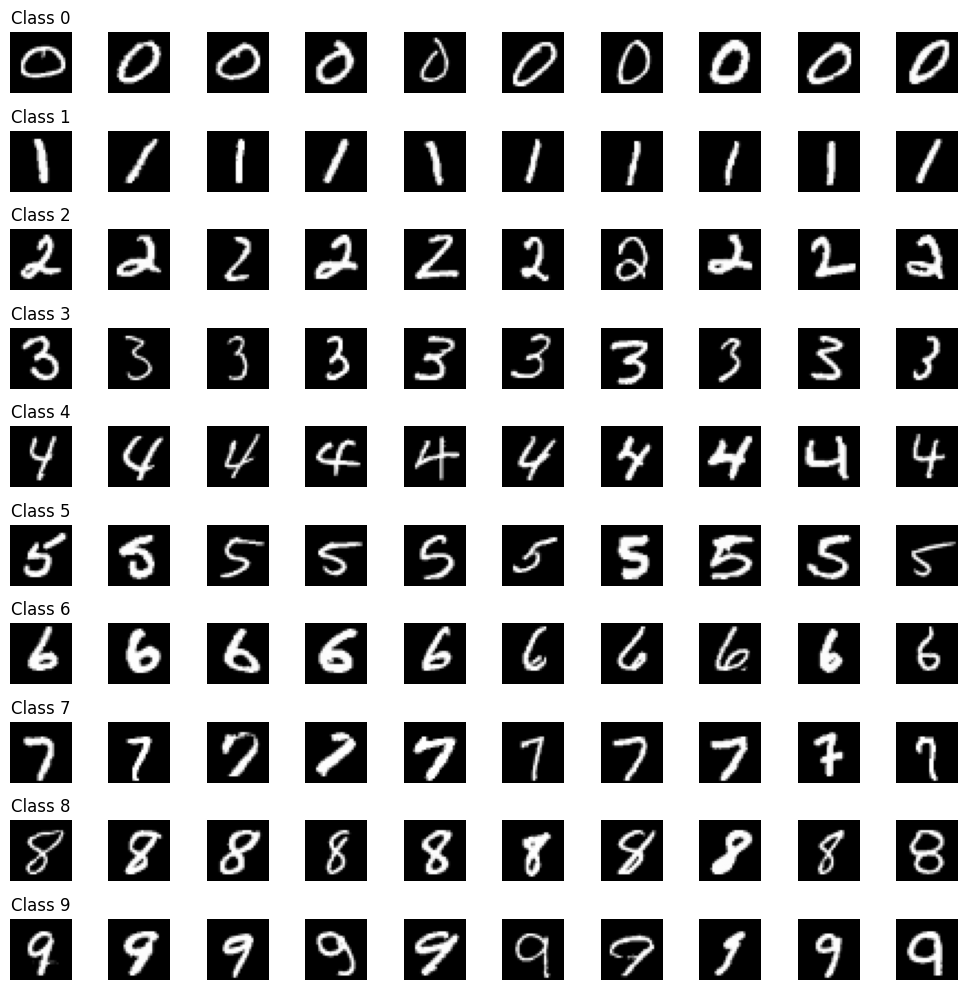

In [9]:
# Troviamo le classi presenti (da 0 a 9)
samples_per_class = 10  # Numero di esempi per classe da visualizzare

# Creiamo una griglia di subplot: righe = n_classes, colonne = samples_per_class
fig, axes = plt.subplots(n_classes, samples_per_class, figsize=(samples_per_class * 1, n_classes * 1))

for i, cls in enumerate(classes):
    # Trova gli indici degli esempi per la classe corrente
    idxs = np.where(y_train == cls)[0]    
    # Mostra l'etichetta sulla prima colonna di ogni riga
    axes[i, 0].set_title(f"Class {cls}")
    j=0    
    # Seleziona randomicamente samples_per_class indici tra quelli della classe corrente
    for idx in random.sample(list(idxs), samples_per_class):
        # Seleziona l'immagine
        img = x_train[idx]
        # Visualizza l'immagine
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        j=j+1

plt.tight_layout()
plt.show()

# Utils

In [10]:
def plot_img(immagine, titolo="Sampled Image", figsize=(4,4)):
    """
    Plotta una immagine, convertendola se necessario da vettoriale (784,) a matrice (28,28).

    Parametri:
    - immagine: numpy array rappresentante l'immagine (forma (784,) o (28,28))
    - titolo: titolo da visualizzare sul plot
    """
    # Se l'immagine è un vettore piatto, la rimodelliamo in 28x28
    if immagine.ndim == 1 or (immagine.ndim == 2 and immagine.shape[0] * immagine.shape[1] == 784):
        immagine = immagine.reshape(28, 28)

    plt.figure(figsize=figsize)
    plt.imshow(immagine, cmap='gray')
    plt.title(titolo)
    plt.axis('off')
    plt.show()

In [11]:
def plot_encoding_tsne(encoder, data, labels, sample_size=None, perplexity=30, random_state=42, title="t-SNE projection of the latent space", figsize=(6, 4)):
    """
    Calcola l'encoding dei dati con il modello encoder e proietta le rappresentazioni latenti in 2D
    utilizzando t-SNE. I punti sono colorati in modo discreto in base alle etichette (classi).

    Parametri:
    - encoder: modello Keras per ottenere l'encoding.
    - dati: array dei dati in input (es. immagini).
    - labels: array delle etichette corrispondenti.
    - sample_size: (opzionale) numero di campioni da utilizzare per t-SNE (se None usa tutti i dati).
    - perplexity: parametro perplexity per t-SNE.
    - random_state: seme per la riproducibilità.
    """
    # Se sample_size è definito e minore del numero totale di dati, campiona casualmente
    if sample_size is not None and sample_size < len(data):
        idx = np.random.choice(len(data), size=sample_size, replace=False)
        data = data[idx]
        labels = labels[idx]

    # Calcola l'encoding dei dati
    _predicted_ = encoder.predict(data)
    if type(_predicted_) == list:
        latent = _predicted_[0]
    else:
        latent = _predicted_

    # Riduci a 2 dimensioni con t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    latent_2d = tsne.fit_transform(latent)

    # Ottieni le etichette uniche
    unique_labels = np.unique(labels)
    # Se ci sono al massimo 10 classi, usiamo 'tab10', altrimenti 'tab20'
    if len(unique_labels) <= 10:
        cmap = plt.get_cmap('tab10', len(unique_labels))
    else:
        cmap = plt.get_cmap('tab20', len(unique_labels))

    plt.figure(figsize=figsize)
    # Plot separato per ogni classe con colori distinti
    for i, ul in enumerate(unique_labels):
        idx = labels == ul
        plt.scatter(latent_2d[idx, 0], latent_2d[idx, 1],
                    color=cmap(i), label=str(ul), s=5)

    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend(title='Classes')
    plt.show()


# Vanilla Autoencoder

In [11]:
flatten_x_train = norm_x_train.reshape((len(norm_x_train), -1))
flatten_x_test = norm_x_test.reshape((len(norm_x_test), -1))

In [12]:
input_dim = flatten_x_train.shape[1]
neurons=(128, 64, 32)
activations=('relu', 'relu', 'relu')
latent_space_dim=2

vannilla_model_type = VanillaAutoencoder.__name__

vanilla_model_params_path = os.path.join(model_path, f"{vannilla_model_type}_{model_name}.parameters.pkl")
vanilla_model_weights_path = os.path.join(model_path, f"{vannilla_model_type}_{model_name}.weights.h5")
if not os.path.exists(vanilla_model_params_path) or not os.path.exists(vanilla_model_weights_path):
    vanilla_model = VanillaAutoencoder(input_dim=input_dim, neurons=neurons, activations=activations, latent_space_dim=latent_space_dim, model_name=model_name)
    optimizer = tf.keras.optimizers.get("Adam")
    optimizer.learning_rate.assign(.0001)
    vanilla_model.compile(optimizer=optimizer, loss='mse')
else:
    vanilla_model = VanillaAutoencoder.load(model_path, model_name)

vanilla_model.print_summaries()

Model: "20250320_175412"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ (None, 2)              │       110,882 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 784)            │       111,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ VanillaAutoencoder_20250320_17… │ (None, 784)            │       222,546 │
│ (Functional)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,546 (869.32 KB)

 Trainable params: 222,546 (869.32 KB)

 Non-trainable params: 0 (0.00 B)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_1 (Dense)         │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_2 (Dense)         │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_layer_3 (Dense)         │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,882 (433.13 KB)

 Trainable params: 110,882 (433.13 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer_1 (Dense)         │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer_2 (Dense)         │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer_3 (Dense)         │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,664 (436.19 KB)

 Trainable params: 111,664 (436.19 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
if not os.path.exists(vanilla_model_params_path) or not os.path.exists(vanilla_model_weights_path):
    history = vanilla_model.train(
                flatten_x_train, 
                flatten_x_test,
                epochs=10,
                batch_size=512,
                shuffle=True)
else:
    history = vanilla_model.get_training_history()

In [14]:
if not os.path.exists(vanilla_model_params_path) or not os.path.exists(vanilla_model_weights_path):
    vanilla_model.save(model_path)

In [15]:
vanilla_encoder = vanilla_model.get_encoder()
vanilla_decoder = vanilla_model.get_decoder()
vanilla_autoencoder = vanilla_model

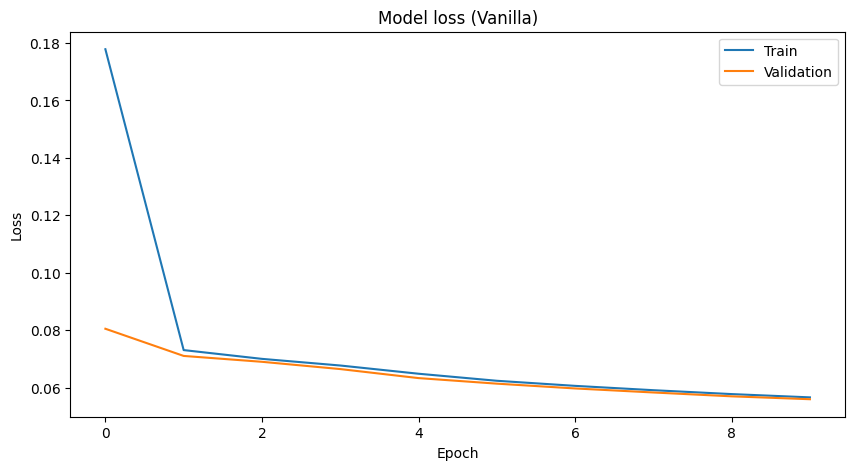

In [16]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (Vanilla)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [17]:
# -------------------------------
# Calcolo delle statistiche dello spazio latente
# (utilizzato per il sampling)
# -------------------------------
latent_reps = vanilla_encoder.predict(flatten_x_train)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [18]:
latent_mean = np.mean(latent_reps, axis=0)
latent_std = np.std(latent_reps, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


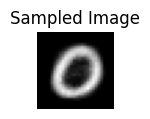

In [19]:
encoded_img = np.random.normal(loc=latent_mean, scale=latent_std, size=(1,latent_space_dim))
# Decodifica per ottenere la ricostruzione
decoded_img = vanilla_decoder.predict(encoded_img)
# Genera una nuova immagine
plot_img(decoded_img, figsize=(1,1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


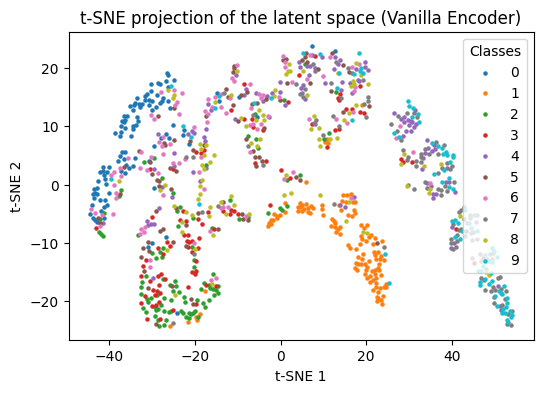

In [20]:
plot_encoding_tsne(vanilla_encoder, flatten_x_test, y_test, sample_size=1000, title=f"t-SNE projection of the latent space (Vanilla Encoder)")

# Convoluted Autoencoder

In [21]:
conv_input_shape = (norm_x_train.shape[1:][0], norm_x_train.shape[1:][1], 1)
conv_filters=(32, 64, 64, 64)
conv_activations=('relu', 'relu', 'relu', 'relu')
conv_kernels=(3, 3, 3, 3)
conv_strides=(1, 2, 2, 1)
conv_latent_space_dim=2

conv_model_type = ConvolutedAutoencoder.__name__

conv_model_params_path = os.path.join(model_path, f"{conv_model_type}_{model_name}.parameters.pkl")
conv_model_weights_path = os.path.join(model_path, f"{conv_model_type}_{model_name}.weights.h5")
if not os.path.exists(conv_model_params_path) or not os.path.exists(conv_model_weights_path):
    conv_model = ConvolutedAutoencoder(
        input_shape=conv_input_shape, 
        filters=conv_filters, 
        kernels=conv_kernels, 
        strides=conv_strides, 
        activations=conv_activations,
        latent_space_dim=conv_latent_space_dim,
        model_name=model_name
    )
    optimizer = tf.keras.optimizers.get("Adam")
    optimizer.learning_rate.assign(.0001)
    conv_model.compile(optimizer=optimizer, loss='mse')
else:
    conv_model = ConvolutedAutoencoder.load(model_path, model_name)

conv_model.print_summaries()

Model: "20250320_175412"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ (None, 2)              │        99,842 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       121,537 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ConvolutedAutoencoder_20250320… │ (None, 28, 28, 1)      │       221,379 │
│ (Functional)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,379 (864.76 KB)

 Trainable params: 220,547 (861.51 KB)

 Non-trainable params: 832 (3.25 KB)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_layer_1 (Conv2D)   │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_relu_1 (Activation)     │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_1                    │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_layer_2 (Conv2D)   │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_relu_2 (Activation)     │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_2                    │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_layer_3 (Conv2D)   │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_relu_3 (Activation)     │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_3                    │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_conv_layer_4 (Conv2D)   │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_relu_4 (Activation)     │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_bn_4                    │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         6,274 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,842 (390.01 KB)

 Trainable params: 99,394 (388.26 KB)

 Non-trainable params: 448 (1.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense (Dense)           │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_transpose_layer_1  │ (None, 7, 7, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_relu_1 (Activation)     │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn_1                    │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_transpose_layer_2  │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_relu_2 (Activation)     │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn_2                    │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_transpose_layer_3  │ (None, 28, 28, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_relu_3 (Activation)     │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_bn_3                    │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_conv_transpose_layer_4  │ (None, 28, 28, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid_layer (Activation)      │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,537 (474.75 KB)

 Trainable params: 121,153 (473.25 KB)

 Non-trainable params: 384 (1.50 KB)

In [22]:
#tf.config.run_functions_eagerly(False)
if not os.path.exists(conv_model_params_path) or not os.path.exists(conv_model_weights_path):
    conv_history = conv_model.train(
                norm_x_train, 
                norm_x_test,
                epochs=10,
                batch_size=512,
                shuffle=True
            )
else:
    conv_history = conv_model.get_training_history()

In [23]:
if not os.path.exists(conv_model_params_path) or not os.path.exists(conv_model_weights_path):
    conv_model.save(model_path)

In [24]:
conv_encoder = conv_model.get_encoder()
conv_decoder = conv_model.get_decoder()
conv_autoencoder = conv_model

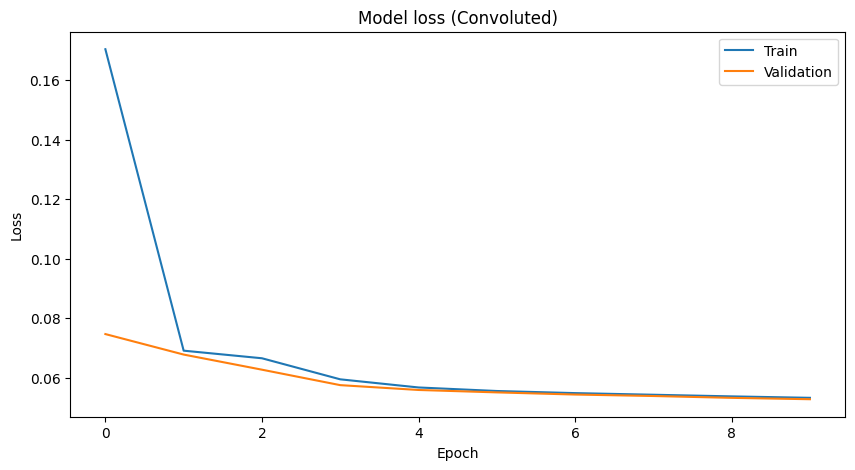

In [25]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(conv_history.history['loss'])
plt.plot(conv_history.history['val_loss'])
plt.title('Model loss (Convoluted)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [26]:
# -------------------------------
# Calcolo delle statistiche dello spazio latente
# (utilizzato per il sampling)
# -------------------------------
conv_latent_reps = conv_encoder.predict(norm_x_train)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step


In [27]:
conv_latent_mean = np.mean(conv_latent_reps, axis=0)
conv_latent_std = np.std(conv_latent_reps, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


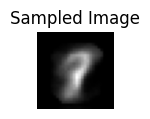

In [28]:
conv_encoded_img = np.random.normal(loc=conv_latent_mean, scale=conv_latent_std, size=(1,latent_space_dim))
# Decodifica per ottenere la ricostruzione
conv_decoded_img = conv_decoder.predict(conv_encoded_img)
# Genera una nuova immagine
plot_img(conv_decoded_img[0], figsize=(1,1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


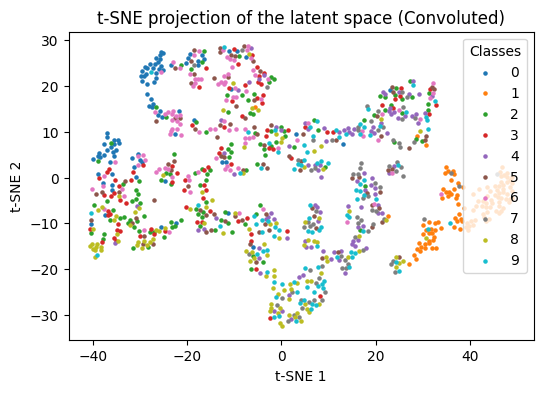

In [29]:
plot_encoding_tsne(conv_encoder, norm_x_test, y_test, sample_size=1000, title=f"t-SNE projection of the latent space (Convoluted)")

# Variational Autoencoder

## Loss Function for Variational Autoencoders

$Loss = \alpha \cdot RMSE + KL$

* $RMSE$  
Root mean squared error. It's the Reconstruction error
* $\alpha$ 
Reconstruction loss weight
* $KL$  
Kullback-Leibler divergence. It measures the _difference_ between a multivariate normal distribution and a multivariate standard normal distribution.  
A standard normal distribution is a normal distribution with mean ($\mu$) equal to 0 and standard deviation ($\sigma$) equal to 1

Kullback-Leibler divergence (Closed-form)  
$D_{KL} (N(\mu,\sigma) || N(0,1))= \frac{1}{2} \sum \left(1+\log(\sigma^2)-\mu^2-\sigma^2\right)$

In [30]:
vae_input_shape = (norm_x_train.shape[1:][0], norm_x_train.shape[1:][1], 1)
vae_filters=(32, 64, 64, 64)
vae_activations=('relu', 'relu', 'relu', 'relu')
vae_kernels=(3, 3, 3, 3)
vae_strides=(1, 2, 2, 1)
vae_latent_space_dim=2

vae_model_type = VariationalAutoencoder.__name__

vae_model_params_path = os.path.join(model_path, f"{vae_model_type}_{model_name}.parameters.pkl")
vae_model_weights_path = os.path.join(model_path, f"{vae_model_type}_{model_name}.weights.h5")
if not os.path.exists(vae_model_params_path) or not os.path.exists(vae_model_weights_path):
    vae_model = VariationalAutoencoder(
        input_shape=vae_input_shape, 
        filters=vae_filters, 
        kernels=vae_kernels, 
        strides=vae_strides, 
        activations=vae_activations,
        latent_space_dim=vae_latent_space_dim,
        model_name=model_name,
        reconstruction_loss_weight=1
    )
    optimizer = tf.keras.optimizers.get("Adam")
    optimizer.learning_rate.assign(.001)
    vae_model.compile(optimizer=optimizer)
else:
    vae_model = VariationalAutoencoder.load(model_path, model_name)

#vae_model.print_summaries()

In [31]:
#tf.config.run_functions_eagerly(False)
if not os.path.exists(vae_model_params_path) or not os.path.exists(vae_model_weights_path):
    vae_history = vae_model.train(
                norm_x_train, 
                norm_x_test,
                epochs=20,
                batch_size=512,
                shuffle=True
            )
else:
    vae_history = vae_model.get_training_history()

In [32]:
if not os.path.exists(vae_model_params_path) or not os.path.exists(vae_model_weights_path):
    vae_model.save(model_path)

In [33]:
vae_encoder = vae_model.get_encoder()
vae_decoder = vae_model.get_decoder()
vae_autoencoder = vae_model

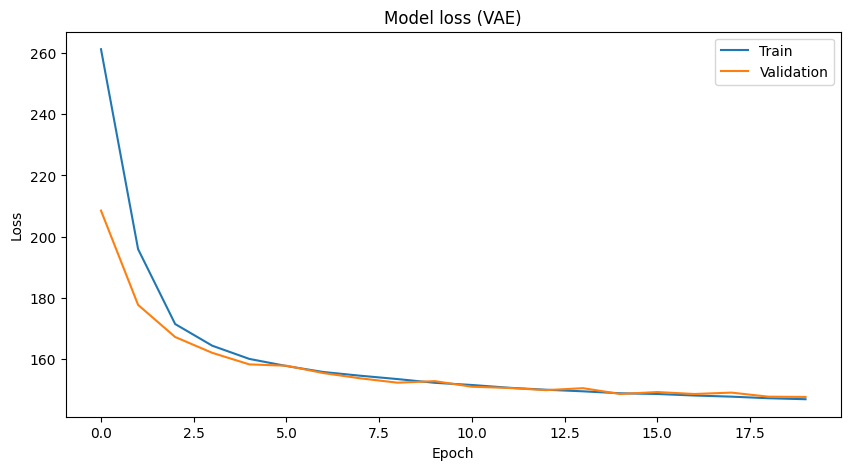

In [34]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(vae_history.history['loss'])
plt.plot(vae_history.history['val_loss'])
plt.title('Model loss (VAE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [35]:
# -------------------------------
# Calcolo delle statistiche dello spazio latente
# (utilizzato per il sampling)
# -------------------------------
vae_latent_reps, _, _ = vae_encoder.predict(norm_x_train)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step


In [36]:
vae_latent_mean = np.mean(vae_latent_reps, axis=0)
vae_latent_std = np.std(vae_latent_reps, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


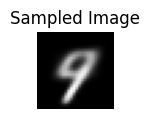

In [37]:
vae_encoded_img = np.random.normal(loc=vae_latent_mean, scale=vae_latent_std, size=(1,latent_space_dim))
# Decodifica per ottenere la ricostruzione
vae_decoded_img = vae_decoder.predict(vae_encoded_img)
# Genera una nuova immagine
plot_img(vae_decoded_img[0], figsize=(1,1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


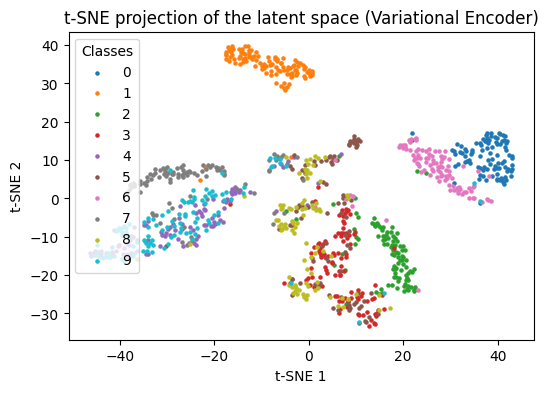

In [38]:
plot_encoding_tsne(vae_encoder, norm_x_test, y_test, sample_size=1000, title=f"t-SNE projection of the latent space (Variational Encoder)")

# Conditioned Variational Autoencoder

In [22]:
import os
import tensorflow as tf
from keras import Model, layers, utils
from keras.api.layers import Input, Concatenate, Dense, Conv2D, Conv2DTranspose, Reshape, Flatten, BatchNormalization, Activation
import numpy as np
from datetime import datetime
import pickle
import abc


In [16]:
class ConditionedVariationalAutoencoder(Autoencoder):
    """
    This class implements a Condiotioned Variational Autoencoder.
    Parameters:
        input_shape: tuple, shape of the input data (height, width, channels)
        input_labels_dim: number of input classes
        filters: tuple of integers, number of filters in each convolutional layer. e.g. (32, 64, 64, 64)
        kernels: tuple of integers, size of the kernel in each convolutional layer. e.g. (3, 3, 3, 3)
        strides: tuple of integers, strides in each convolutional layer. e.g. (1, 2, 2, 1)
        activations: tuple of strings, activations in each convolutional layer. e.g. ('relu', 'relu', 'relu', 'relu')
        latent_space_dim: integer, dimension of the latent space
        model_name: str, name of the model (optional)
    """

    def __init__(
            self,
            input_shape,
            input_labels_dim,
            filters,           # dimension of the output space
            kernels,           # size of the convolution window
            strides,
            activations,
            latent_space_dim,
            model_name=None,
            reconstruction_loss_weight = 1000,
            **kwargs
        ):
        if len(filters) != len(kernels) != len(strides) != len(activations):
            raise ValueError("The length of the following lists must be the same: filters, kernels, strides, activations")        

        self._input_shape = input_shape
        self._input_labels_dim = input_labels_dim
        self._latent_space_dim = latent_space_dim
        self._filters = filters
        self._kernels = kernels
        self._strides = strides
        self._activations = activations        
        self._num_layers = len(filters)
        self._shape_before_bottleneck = None
        self._reconstruction_loss_weight = reconstruction_loss_weight

        #creating the 3 loss trackers
        self._total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self._reconstruction_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self._kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

        super(ConditionedVariationalAutoencoder, self).__init__(latent_space_dim, model_name, **kwargs)

    class Sampling(layers.Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
            return z_mean + tf.exp(0.5* z_log_var) * epsilon

    def _build(self):
        # Encoder
        # Create Input layers
        encoder_data_input = Input(shape=self._input_shape, name="encoder_data_input")
        encoder_label_input = Input(shape=(self._input_labels_dim,), name="encoder_label_input")
        # Create all convolutional blocks in encoder
        x = encoder_data_input
        for layer_index in range(self._num_layers):
            layer_number = layer_index + 1
            conv_layer = Conv2D(
                filters=self._filters[layer_index],          # (int) dimension of the output space
                kernel_size=self._kernels[layer_index],      # (tuple) size of the convolution window
                strides=self._strides[layer_index],
                activation=self._activations[layer_index],
                padding="same",
                name=f"encoder_conv_layer_{layer_number}_with_activation_{self._activations[layer_index]}"
            )
            x = conv_layer(x)

        # Create Bottleneck
        self._shape_before_bottleneck = x.shape[1:]        
        x = Flatten()(x)
        # Concatenate Input data and class labels
        x = Concatenate()([x, encoder_label_input])
        x = Activation(self._activations[layer_index], name=f"encoder_bn_relu")(x)
        x = BatchNormalization(name=f"encoder_bn_batch_norm")(x)
        z_mu = Dense(self._latent_space_dim, name="mu")(x)
        z_log_var = Dense(self._latent_space_dim, name="log_variance")(x)
        z = self.Sampling(name="encoder_output")([z_mu, z_log_var])

        # Define the model (multiple output defined in the array [z, z_mu, z_log_var])
        encoder = Model([encoder_data_input, encoder_label_input], [z, z_mu, z_log_var] , name="encoder")

        # Decoder
        # Create Input layers
        decoder_data_input = Input(shape=(self._latent_space_dim,), name="decoder_data_input")
        decoder_label_input = Input(shape=(self._input_labels_dim,), name="decoder_label_input")
        # Concatenate Input layers
        x = Concatenate()([decoder_data_input, decoder_label_input])
        # Create a Dense layer
        num_neurons = np.prod(self._shape_before_bottleneck) # [1, 2, 4] -> 8
        #dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
        x = Dense(num_neurons, activation="relu", name="decoder_dense")(x)
        # Create a Reshape layer
        x = Reshape(self._shape_before_bottleneck)(x)
        # Create all convolutional blocks in decoder
        for layer_index in reversed(range(1, self._num_layers)):
            layer_num = self._num_layers - layer_index
            conv_transpose_layer = Conv2DTranspose(
                filters=self._filters[layer_index],
                kernel_size=self._kernels[layer_index],
                strides=self._strides[layer_index],
                activation=self._activations[layer_index],
                padding="same",
                name=f"decoder_conv_transpose_layer_{layer_num}"
            )
            x = conv_transpose_layer(x)
        # Create output layer
        conv_transpose_layer = Conv2DTranspose(
                filters=self._input_shape[-1], # Get the latest dimension of the input shape
                kernel_size=self._kernels[0],
                strides=self._strides[0],
                activation="sigmoid",
                padding="same",
                name=f"decoder_conv_transpose_layer_{self._num_layers}_with_activation_sigmoid"
            )
        decoder_output = conv_transpose_layer(x)
        # Define the model
        decoder = Model([decoder_data_input, decoder_label_input], decoder_output, name="decoder")

        self._encoder = encoder
        self._decoder = decoder        

    def _get_parameters_to_save(self):
        return [
            self._input_shape,            
            self._filters,
            self._kernels,
            self._strides,
            self._activations,
            self._latent_space_dim,
            self.name
        ]

    @property
    def metrics(self):
        return [ self._total_loss_tracker, self._reconstruction_loss_tracker, self._kl_loss_tracker ]

    def _custom_loss(self, input_data, input_labels):
        encoded, mean, log_var = self._encoder([input_data, input_labels])
        decoded = self._decoder([encoded, input_labels])
        recon_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(input_data, decoded), axis =(1, 2))
        recon_loss = tf.reduce_mean(recon_loss)
        kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = self._reconstruction_loss_weight * recon_loss + kl_loss
        return total_loss, recon_loss, kl_loss

    def train(self, x_train, x_val, batch_size, epochs, shuffle=True):
        self._training_history = self.fit(
            x_train, 
            x_train,
            validation_data=(x_val, x_val),
            batch_size=batch_size,
            shuffle=shuffle,
            epochs=epochs
        )
        return self._training_history

    def train_step(self, data):
        #print(len(data))
        x, y = data
        #print(len(x))
        in_data, in_labels = x
        #print(in_data.shape)
        with tf.GradientTape() as tape:
            total_loss, recon_loss, kl_loss = self._custom_loss(in_data, in_labels)
            grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self._total_loss_tracker.update_state(total_loss)
        self._reconstruction_loss_tracker.update_state(recon_loss)
        self._kl_loss_tracker.update_state(kl_loss)
        return { m.name : m.result() for m in self.metrics }

    def test_step(self, data):
        # Unpack the data
        x, y = data
        in_data, in_labels = x
        # Compute predictions
        y_pred = self(x, training=False)
        # Updates the metrics tracking the loss
        total_loss, recon_loss, kl_loss = self._custom_loss(self, in_data, in_labels)
        self._total_loss_tracker.update_state(total_loss)
        self._reconstruction_loss_tracker.update_state(recon_loss)
        self._kl_loss_tracker.update_state(kl_loss)

        # Update the metrics.
        for metric in self.metrics:
            if metric.name != "loss":
                metric.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

    def call(self, x):
        encoded, mu, log_var = self._encoder(x)
        decoded = self._decoder(encoded)
        return decoded



In [18]:
cvae_input_shape = (norm_x_train.shape[1:][0], norm_x_train.shape[1:][1], 1)
cvae_innput_labels_dim = n_classes
cvae_filters=(32, 64, 64, 64)
cvae_activations=('relu', 'relu', 'relu', 'relu')
cvae_kernels=(3, 3, 3, 3)
cvae_strides=(1, 2, 2, 1)
cvae_latent_space_dim=2

cvae_model_type = ConditionedVariationalAutoencoder.__name__

cvae_model_params_path = os.path.join(model_path, f"{cvae_model_type}_{model_name}.parameters.pkl")
cvae_model_weights_path = os.path.join(model_path, f"{cvae_model_type}_{model_name}.weights.h5")
if not os.path.exists(cvae_model_params_path) or not os.path.exists(cvae_model_weights_path):
    cvae_model = ConditionedVariationalAutoencoder(
        input_shape=cvae_input_shape, 
        input_labels_dim=cvae_innput_labels_dim,
        filters=cvae_filters, 
        kernels=cvae_kernels, 
        strides=cvae_strides, 
        activations=cvae_activations,
        latent_space_dim=cvae_latent_space_dim,
        model_name=model_name,
        reconstruction_loss_weight=1
    )
    optimizer = tf.keras.optimizers.get("Adam")
    optimizer.learning_rate.assign(.001)
    cvae_model.compile(optimizer=optimizer)
else:
    cvae_model = ConditionedVariationalAutoencoder.load(model_path, model_name)

#cvae_model.print_summaries()

In [23]:
#tf.config.run_functions_eagerly(False)
y_train_cat = utils.to_categorical(y_train, num_classes=cvae_innput_labels_dim)
y_test_cat = utils.to_categorical(y_test, num_classes=cvae_innput_labels_dim)
if not os.path.exists(cvae_model_params_path) or not os.path.exists(cvae_model_weights_path):
    cvae_history = cvae_model.train(
        (norm_x_train, y_train_cat),
        (norm_x_test, y_test_cat),
        epochs=20,
        batch_size=512,
        shuffle=True
    )
else:
    cvae_history = cvae_model.get_training_history()

Epoch 1/20


KeyboardInterrupt: 

In [ ]:
if not os.path.exists(cvae_model_params_path) or not os.path.exists(cvae_model_weights_path):
    cvae_model.save(model_path)

In [ ]:
cvae_encoder = cvae_model.get_encoder()
cvae_decoder = cvae_model.get_decoder()
cvae_autoencoder = cvae_model

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(cvae_history.history['loss'])
plt.plot(cvae_history.history['val_loss'])
plt.title('Model loss (CVAE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# -------------------------------
# Calcolo delle statistiche dello spazio latente
# (utilizzato per il sampling)
# -------------------------------
cvae_latent_reps, _, _ = cvae_encoder.predict(norm_x_train)

In [ ]:
cvae_latent_mean = np.mean(cvae_latent_reps, axis=0)
cvae_latent_std = np.std(cvae_latent_reps, axis=0)

In [ ]:
cvae_encoded_img = np.random.normal(loc=cvae_latent_mean, scale=cvae_latent_std, size=(1,latent_space_dim))
# Decodifica per ottenere la ricostruzione
cvae_decoded_img = cvae_decoder.predict(cvae_encoded_img)
# Genera una nuova immagine
plot_img(cvae_decoded_img[0], figsize=(1,1))

In [ ]:
plot_encoding_tsne(cvae_encoder, [norm_x_test, y_test], y_test, sample_size=1000, title=f"t-SNE projection of the latent space (Conditioned Variational Encoder)")

# Latent Spaces Analysis

In [ ]:
plot_encoding_tsne(vanilla_encoder, flatten_x_train, y_train, sample_size=1000, title=f"t-SNE projection of the latent space (Vanilla Encoder)")

In [ ]:
plot_encoding_tsne(conv_encoder, norm_x_train, y_train, sample_size=1000, title=f"t-SNE projection of the latent space (Convoluted Encoder)")

In [ ]:
plot_encoding_tsne(vae_encoder, norm_x_train, y_train, sample_size=1000, title=f"t-SNE projection of the latent space (Variational Encoder)")

In [ ]:
plot_encoding_tsne(cvae_encoder, [norm_x_train, y_train], y_train, sample_size=1000, title=f"t-SNE projection of the latent space (Conditioned Variational Encoder)")

In [ ]:
class_to_analyze = 8
indexes_to_analyze = [i for i,x in enumerate(y_train) if x == class_to_analyze]
norm_x_train_to_analyze = norm_x_train[indexes_to_analyze]
y_train_to_analyze = y_train[indexes_to_analyze]

plot_encoding_tsne(vae_encoder, norm_x_train_to_analyze, y_train_to_analyze, sample_size=None, title=f"t-SNE projection of the latent space (Variational Encoder) of class {class_to_analyze}")
plot_encoding_tsne(conv_encoder, norm_x_train_to_analyze, y_train_to_analyze, sample_size=None, title=f"t-SNE projection of the latent space (Convoluted Encoder) of class {class_to_analyze}")
plot_encoding_tsne(cvae_encoder, [norm_x_train_to_analyze, y_train_to_analyze], y_train_to_analyze, sample_size=None, title=f"t-SNE projection of the latent space (Conditioned Variational Encoder) of class {class_to_analyze}")